In [23]:
import cv2
import torch
import numpy as np
import timm
import pandas as pd
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN
from torchvision import transforms
from PIL import Image

In [24]:
# Carregar modelo XceptionNet pré-treinado para detecção de deepfakes
class DeepfakeDetector(torch.nn.Module):
    def __init__(self):
        super(DeepfakeDetector, self).__init__()
        self.model = timm.create_model("xception", pretrained=True, num_classes=2)

    def forward(self, x):
        return self.model(x)

In [25]:
# Inicializar modelo e definir dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepfakeDetector().to(device)
model.eval()

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


DeepfakeDetector(
  (model): Xception(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): ReLU(inplace=True)
    (block1): Block(
      (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rep): Sequential(
        (0): SeparableConv2d(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(in

In [26]:
# Transformações para normalização
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [27]:
# Função para extrair frames do vídeo
def extract_frames(video_path, interval=5):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % interval == 0:
            frames.append(frame)
        frame_count += 1

    cap.release()
    return frames

In [ ]:
import os
import shutil

# Criar ou limpar o diretório para armazenar as faces extraídas
output_dir = "faces_extraidas"
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)  # Remove todos os arquivos da pasta
os.makedirs(output_dir, exist_ok=True)  # Recria a pasta limpa

# Função para detectar rostos nos frames usando MTCNN
def detect_faces(frames):
    mtcnn = MTCNN(keep_all=True, device=device)
    faces = []
    for i, frame in enumerate(frames):
#    for frame in frames:
        image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        boxes, _ = mtcnn.detect(image)

#        if boxes is not None:
#            for box in boxes:
#                x1, y1, x2, y2 = map(int, box)
#                face = image.crop((x1, y1, x2, y2))
#                faces.append((frame, face))

        if boxes is not None:
            for j, box in enumerate(boxes):
                x1, y1, x2, y2 = map(int, box)
                face = image.crop((x1, y1, x2, y2))
                
                # Salvar a face extraída como imagem
                face_filename = os.path.join(output_dir, f"frame_{i}_face_{j}.jpg")
                face.save(face_filename)

                # Adicionar à lista de resultados
                faces.append((frame, face))

    return faces

In [29]:
# Função para classificar rostos como real ou deepfake
def classify_faces(faces):
    results = []
    for frame, face in faces:
        face = transform(face).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(face)
            prob = torch.softmax(output, dim=1)[0]
            label = "Deepfake" if prob[1] > prob[0] else "Real"
            confidence = prob[1].item() if label == "Deepfake" else prob[0].item()
            results.append((frame, label, confidence))

    return results

In [30]:
# Função para exibir resultados
def display_results(results):
    df = pd.DataFrame(results, columns=["Frame", "Classificação", "Confiança"])
    df.drop(columns=["Frame"], inplace=True)
    print(df)

    plt.figure(figsize=(8, 5))
    real_count = sum(1 for _, label, _ in results if label == "Real")
    deepfake_count = sum(1 for _, label, _ in results if label == "Deepfake")
    
    plt.bar(["Real", "Deepfake"], [real_count, deepfake_count], color=["blue", "red"])
    plt.title("Distribuição de Detecção de Deepfakes")
    plt.ylabel("Número de Frames")
    plt.show()

In [31]:
# Pipeline completo
def detect_deepfakes(video_path):
    print("Extraindo quadros...")
    frames = extract_frames(video_path)

    print("Detectando rostos...")
    faces = detect_faces(frames)

    print("Classificando rostos...")
    results = classify_faces(faces)

    print("Exibindo resultados...")
    display_results(results)

Extraindo quadros...
Detectando rostos...
Classificando rostos...
Exibindo resultados...
   Classificação  Confiança
0           Real   0.560494
1           Real   0.544340
2           Real   0.540314
3           Real   0.540554
4           Real   0.539910
..           ...        ...
90          Real   0.529524
91          Real   0.522556
92          Real   0.513017
93          Real   0.512062
94          Real   0.515448

[95 rows x 2 columns]


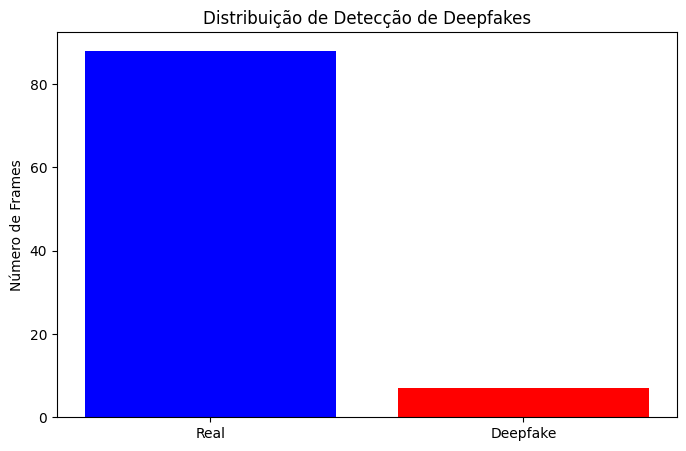

In [32]:
# Executar a detecção em um vídeo MP4
#video_file = "videos_teste/id4_0009.mp4"      # Real
video_file = "videos_teste/id0_id9_0008.mp4"  # Fake
detect_deepfakes(video_file)